# Download FreeBase mid dictionary

In [1]:
from pandas import read_csv
from google_drive_downloader import GoogleDriveDownloader as gdd

# gdd.download_file_from_google_drive(file_id='0B52yRXcdpG6MaHA5ZW9CZ21MbVk',
#                                     dest_path='data/mid2entity.tsv.gz',
#                                     unzip=True)

mid2name = read_csv('data/mid2entity.tsv.gz',sep='\t',compression='gzip', names=['mid','entity'])
mid2ent = {i:e for i,e in zip(mid2name['mid'],mid2name['entity'])}
mid2ent

{'/m/0gw0': 'Anarcism',
 '/m/0gwj': 'Autisim',
 '/m/0gx0': 'Albedo rate',
 '/m/0gxj': 'Abû Zabi',
 '/m/0gy0': 'A.',
 '/m/0gyh': 'Alabama (state)',
 '/m/0gy_': 'Achillies',
 '/m/0gzh': 'President Abraham',
 '/m/0gz_': 'The Stagirite',
 '/m/0g_h': 'AnAmericanInParis',
 '/m/0g_w': 'The Oscars',
 '/m/0h0c': 'Animalia (book)',
 '/m/0h0q': 'Atomic time',
 '/m/0h16': 'Altruistically',
 '/m/0h1p': '李安',
 '/m/0h25': 'Ayb rand',
 '/m/0h2p': 'Allan Connes',
 '/m/0h34': 'Allen Dwan',
 '/m/0h3y': "Ad-Dimuqratiyah ash-Sha'biyah",
 '/m/0h53': 'Ayn Rand Atlas Shrugged',
 '/m/0h5k': 'Historical anthropologist',
 '/m/0h61': 'Archeology',
 '/m/0h6k': 'The Agricultural Sciences',
 '/m/0h70': 'Alchemist',
 '/m/0h7j': 'Automatic dependent surveillance broadcast',
 '/m/0h7x': 'Austrian Republic',
 '/m/0h8d': 'America Samoa',
 '/m/0h9c': 'Astronom',
 '/m/0h9v': 'Theratromyxa',
 '/m/0hb8': 'Bemer-Ross Code',
 '/m/0hcr': 'Animated images',
 '/m/0hd7': 'Phanaeus',
 '/m/0hdr': 'Andre Kirk Agassi',
 '/m/0hf7': 'Mo

# Train Freebase KG

In [2]:
from torch import cuda
from torch.optim import Adam

from torchkge.models import TransRModel
from torchkge.sampling import BernoulliNegativeSampler
from torchkge.utils import MarginLoss, DataLoader
from torchkge.utils.datasets import load_fb15k
from tqdm.autonotebook import tqdm

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [3]:
# Load dataset
kg_train, kg_valid, kg_test = load_fb15k()

In [4]:
def check_mid(mid):
    
    fb_mid = mid2ent
    kg_mid = kg_train.ent2ix
    
    if mid in fb_mid and mid in kg_mid:
        print(f'True: ({mid}):({mid2ent[mid]}) is valid for both freebase and knowledge graph')
    elif mid in fb_mid and mid not in kg_mid:
        print(f'False: ({mid}):({mid2ent[mid]}) is not valid for knowledge graph')
    elif (mid not in fb_mid) and (mid in kg_mid):
        print(f'False: {mid} is not valid for freebase')
    else:
        print(f'False: {mid} is not valid for both freebase and knowledge graph')

In [5]:
target_mid = ['/m/011v3', 
              '/m/03x6m',
              '/m/06l22',
              '/m/0hvgt',
              '/m/045xx',
              '/m/023fb',
              '/m/050fh' ,
              '/m/01634x' ,
              '/m/0xbm',
              '/m/0hvjr', 
              '/m/04ltf', 
              '/m/01w_d6', 
              '/m/0175rc', 
              '/m/01_1kk', 
              '/m/03w7kx', 
              '/m/019lxm', 
              '/m/023zd7', 
              '/m/02bh_v', 
              '/m/06qjgc',
              '/m/0y54',
              '/m/0kqbh',
              '/m/0jgd',
              '/m/02y9kd',
            ]

In [6]:
for t in target_mid:
    check_mid(t)

True: (/m/011v3):(Milan A.C.) is valid for both freebase and knowledge graph
True: (/m/03x6m):(Internazionale) is valid for both freebase and knowledge graph
True: (/m/06l22):(Royal Madrid) is valid for both freebase and knowledge graph
True: (/m/0hvgt):(CF Barcelona) is valid for both freebase and knowledge graph
True: (/m/045xx):(Juventus fc) is valid for both freebase and knowledge graph
True: (/m/023fb):(Chelsea F.C. season 2011-12) is valid for both freebase and knowledge graph
True: (/m/050fh):(Man UTD) is valid for both freebase and knowledge graph
True: (/m/01634x):(Man c) is valid for both freebase and knowledge graph
True: (/m/0xbm):(Arsenal fc) is valid for both freebase and knowledge graph
True: (/m/0hvjr):(Tottenham Hotspur Foundation) is valid for both freebase and knowledge graph
True: (/m/04ltf):(Liverpool football club) is valid for both freebase and knowledge graph
True: (/m/01w_d6):(BV Borussia Dortmund) is valid for both freebase and knowledge graph
True: (/m/0175rc

In [7]:
target_ix = [kg_train.ent2ix[m] for m in target_mid[:-1]]

In [8]:
def training(ent_emb_dim=10, rel_emb_dim=10, lr=0.0004, n_epochs=100, b_size=32768, margin=0.5):
    
    # Define the model and criterion
    model = TransRModel(ent_emb_dim, rel_emb_dim, kg_train.n_ent, kg_train.n_rel)
    criterion = MarginLoss(margin)
    
    # Move everything to CUDA if available
    if cuda.is_available():
        cuda.empty_cache()
        model.cuda()
        criterion.cuda()
        
    # Define the torch optimizer to be used
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    
    # KG training options
    sampler = BernoulliNegativeSampler(kg_train)
    dataloader = DataLoader(kg_train, batch_size=b_size, use_cuda='all')
    
    # Training
    iterator = tqdm(range(n_epochs), unit='epoch')
    for epoch in iterator:
        running_loss = 0.0
        for i, batch in enumerate(dataloader):
            h, t, r = batch[0], batch[1], batch[2]
            n_h, n_t = sampler.corrupt_batch(h, t, r)

            optimizer.zero_grad()

            # forward + backward + optimize
            pos, neg = model(h, t, n_h, n_t, r)
            loss = criterion(pos, neg)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        iterator.set_description(
            'Epoch {} | mean loss: {:.5f}'.format(epoch + 1, running_loss / len(dataloader)))
    model.normalize_parameters()
    
    return model

## Epcoh : 10

In [9]:
model = training(n_epochs=10)
ent, _, _ = model.get_embeddings()
ent_embedded = TSNE(n_components=2).fit_transform(ent.cpu())
x = ent_embedded[:,0]
y = ent_embedded[:,1]
valid_mid = [kg_train.ix2ent[i] for i in range(kg_train.n_ent)] # set of
annotate = [mid2ent[m] if m in mid2ent else None for m in valid_mid] 

  0%|          | 0/10 [00:00<?, ?epoch/s]

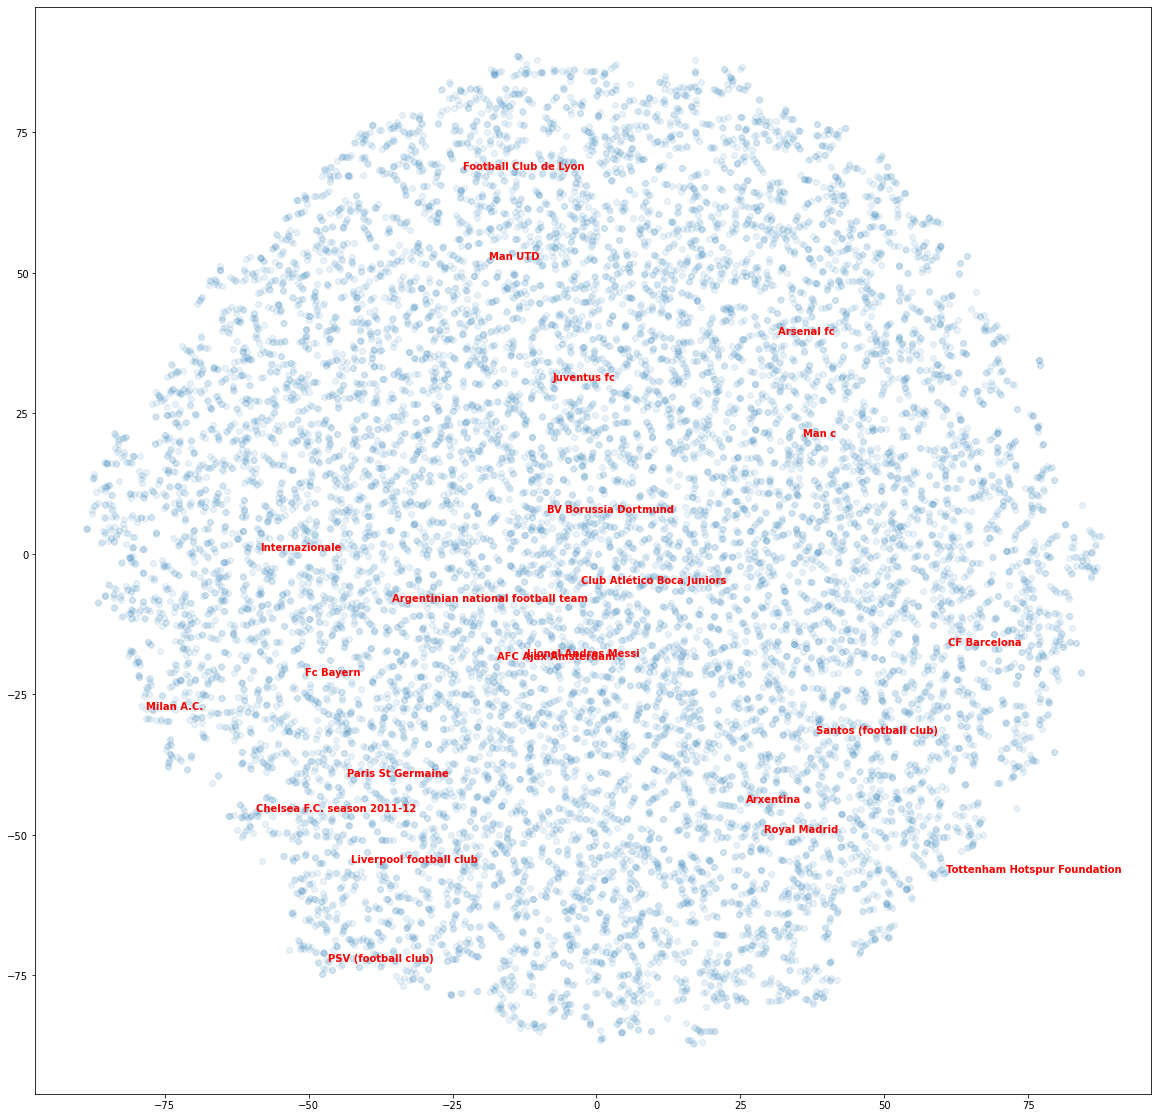

In [10]:
plt.figure(figsize=(20,20))
for idx in target_ix:  
    plt.text(x[idx],y[idx],annotate[idx],color='red', weight="bold")
plt.scatter(x,y, alpha=0.1);

## Epoch: 300

In [11]:
model = training(n_epochs=300)
ent, _, _ = model.get_embeddings()
ent_embedded = TSNE(n_components=2).fit_transform(ent.cpu())
x = ent_embedded[:,0]
y = ent_embedded[:,1]
valid_mid = [kg_train.ix2ent[i] for i in range(kg_train.n_ent)]
annotate = [mid2ent[m] if m in mid2ent else None for m in valid_mid] 

  0%|          | 0/300 [00:00<?, ?epoch/s]

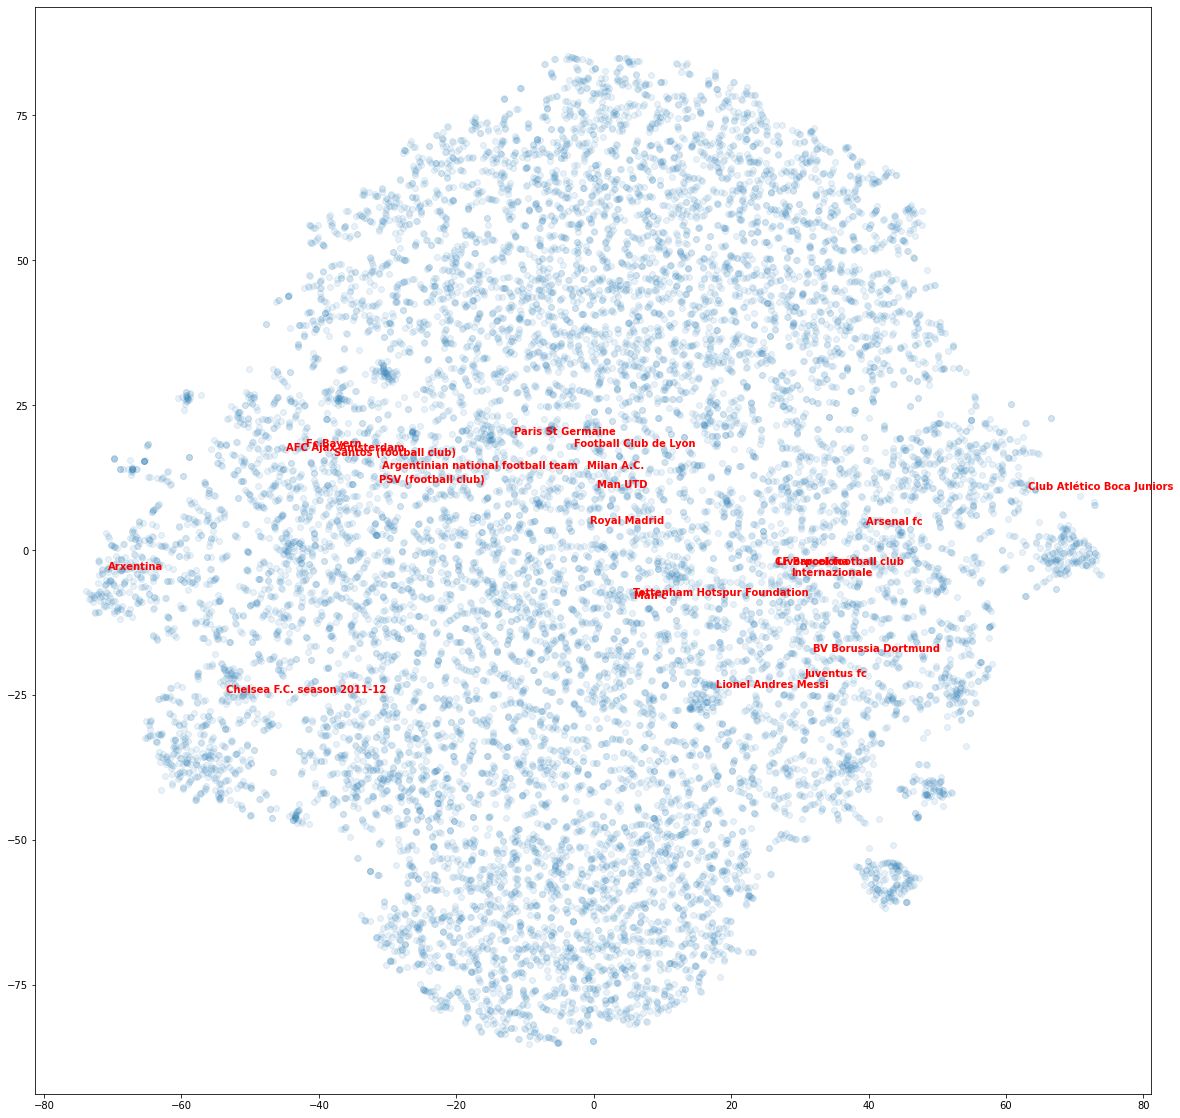

In [12]:
plt.figure(figsize=(20,20))
for idx in target_ix:  
    plt.text(x[idx],y[idx],annotate[idx],color='red', weight="bold")
plt.scatter(x,y, alpha=0.1);

## Epoch: 1000

In [15]:
model = training(n_epochs=1000)
ent, _, _ = model.get_embeddings()
ent_embedded = TSNE(n_components=2).fit_transform(ent.cpu())
x = ent_embedded[:,0]
y = ent_embedded[:,1]
valid_mid = [kg_train.ix2ent[i] for i in range(kg_train.n_ent)]
annotate = [mid2ent[m] if m in mid2ent else None for m in valid_mid] 

  0%|          | 0/1000 [00:00<?, ?epoch/s]

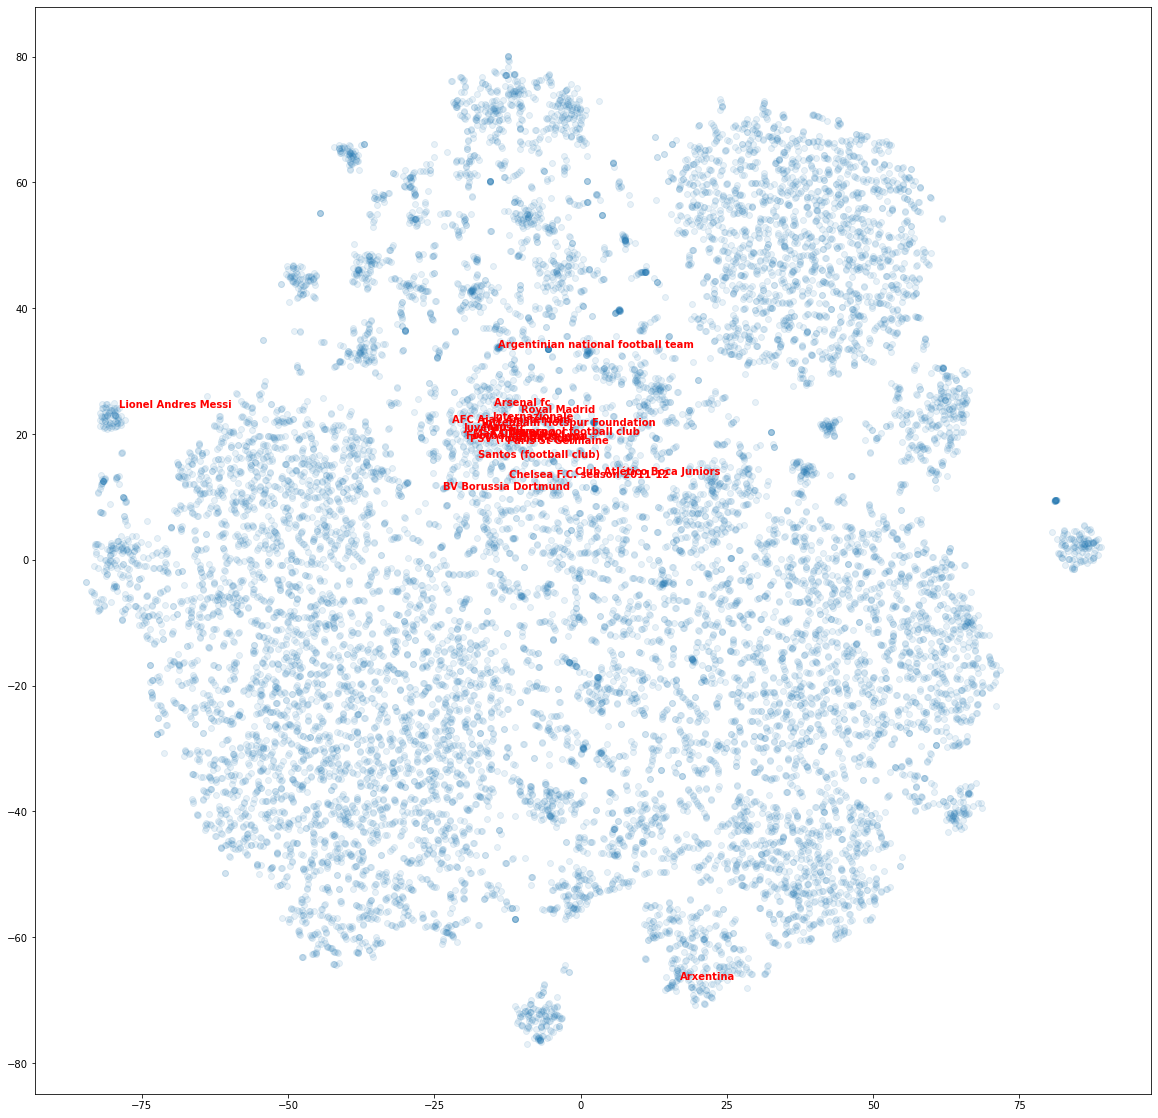

In [16]:
plt.figure(figsize=(20,20))
for idx in target_ix:  
    plt.text(x[idx],y[idx],annotate[idx],color='red', weight="bold")
plt.scatter(x,y, alpha=0.1);

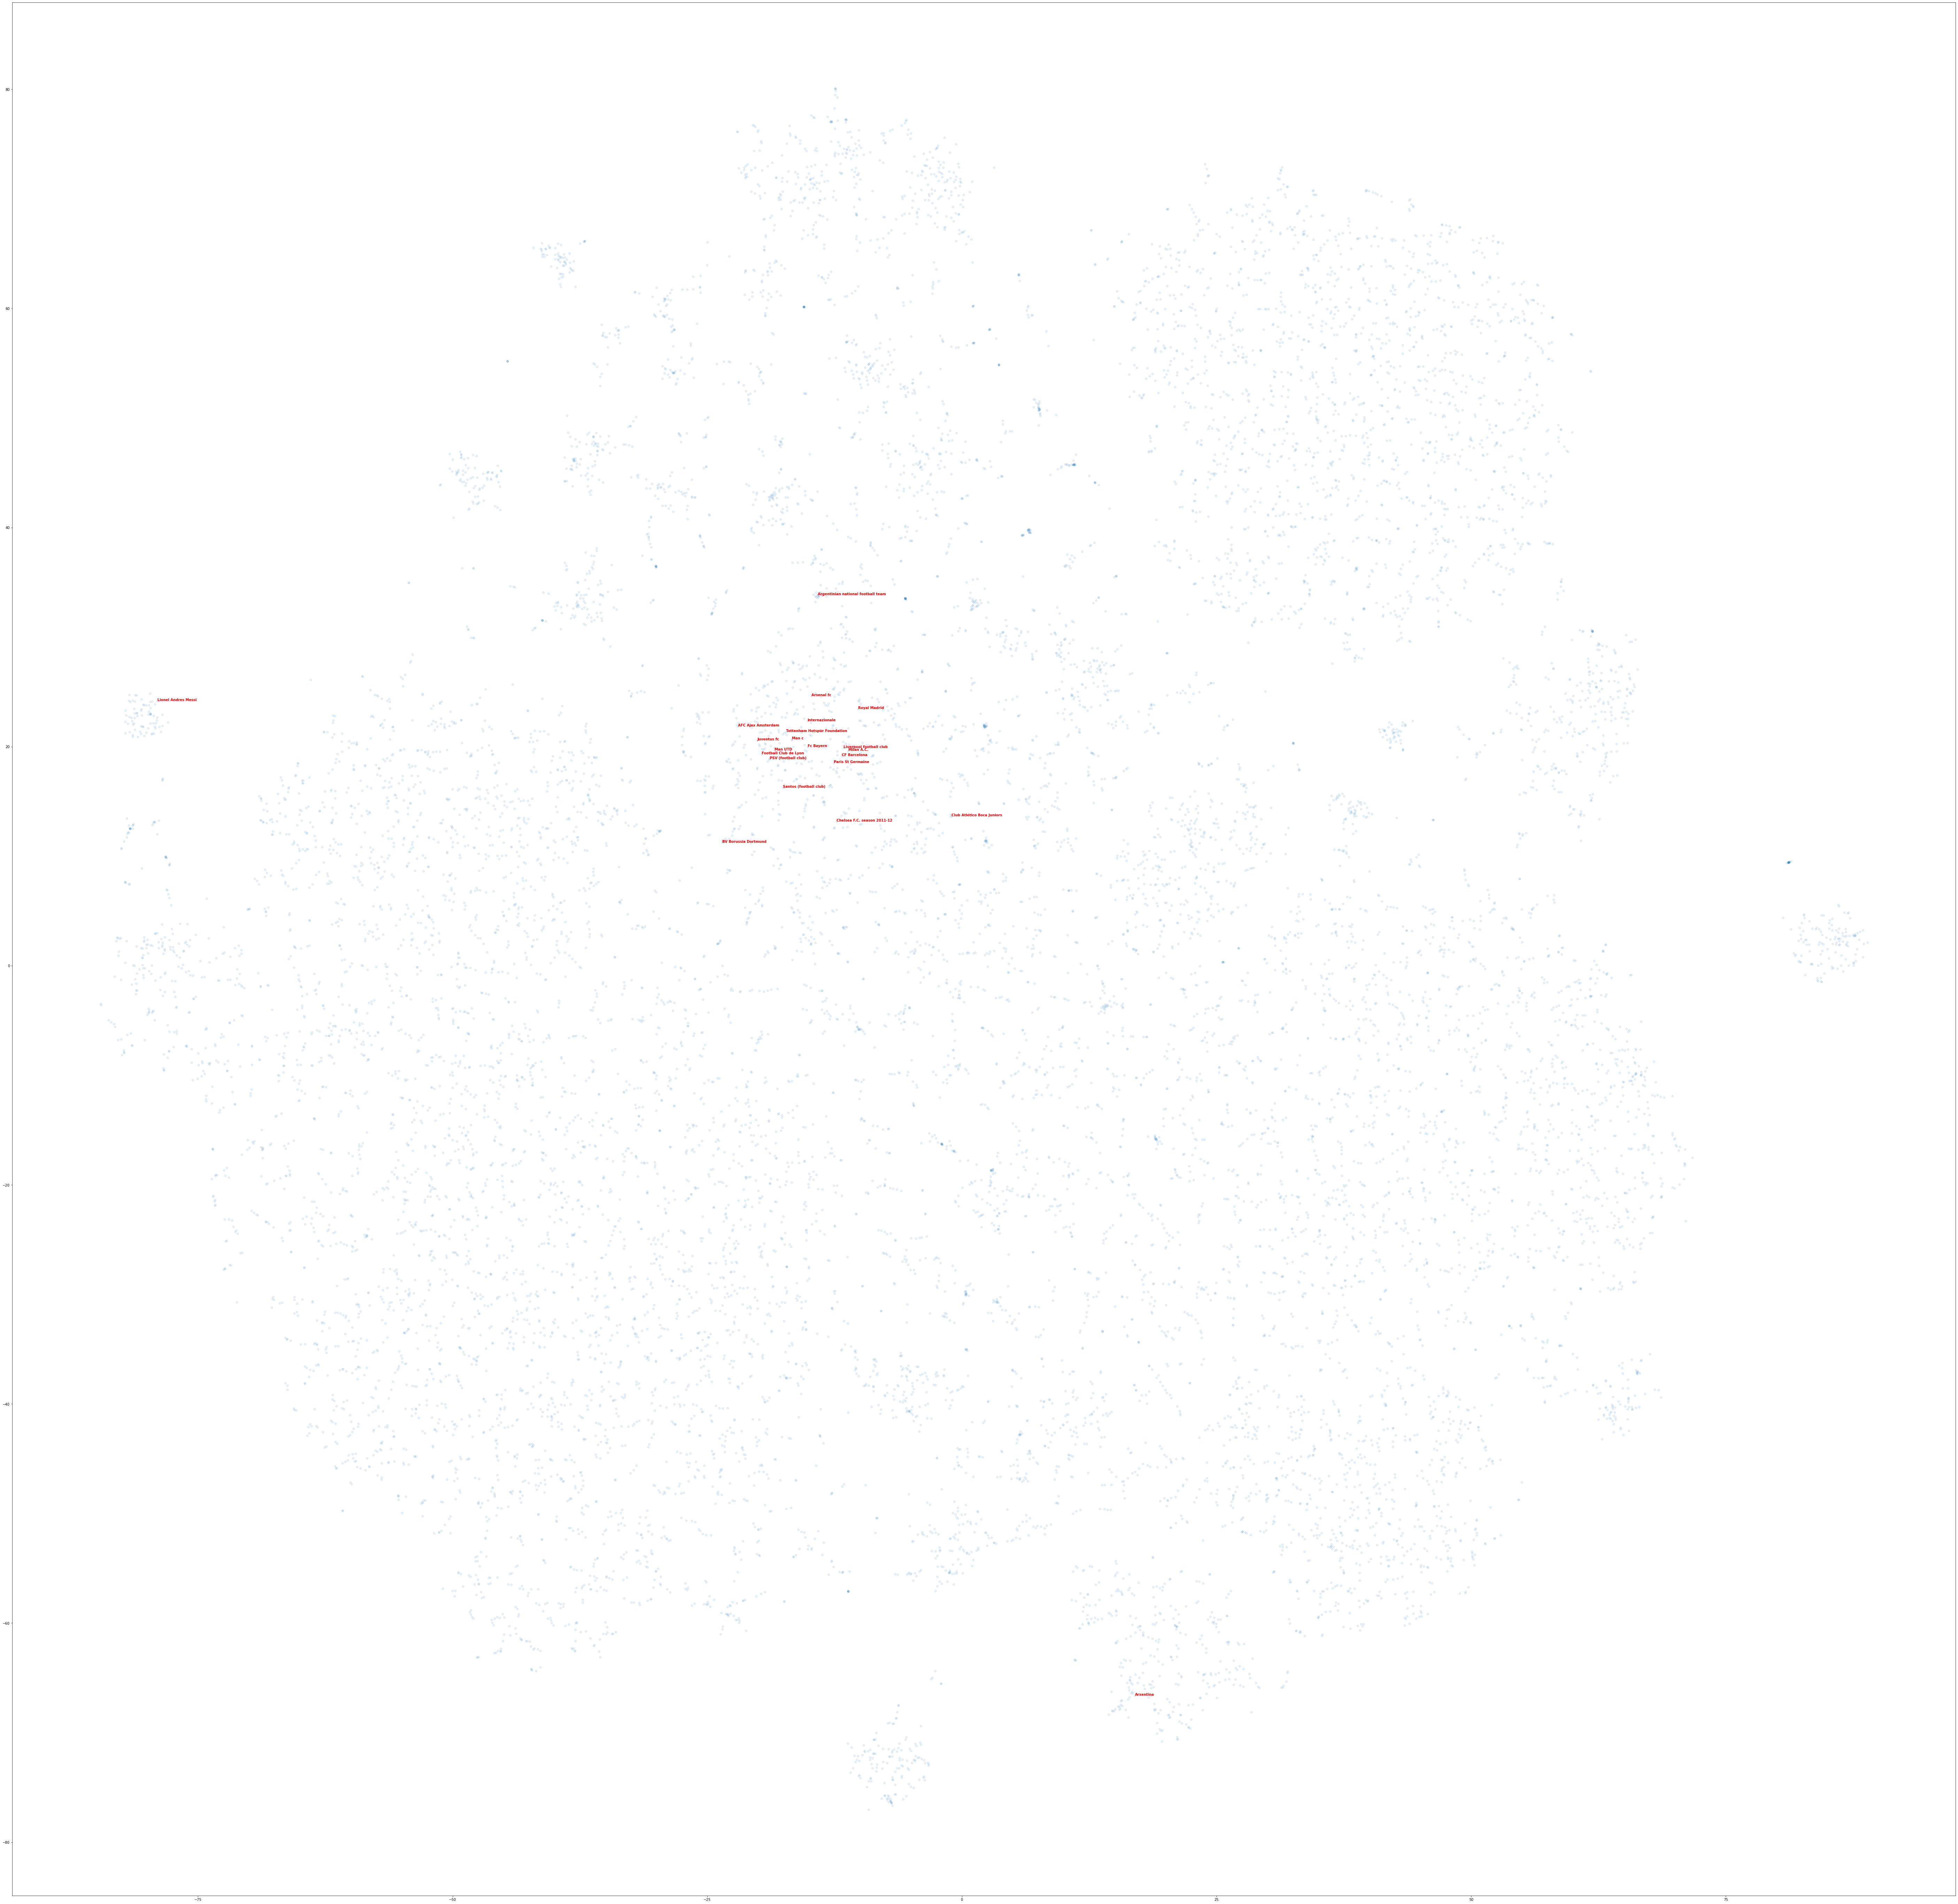

In [18]:
plt.figure(figsize=(100,100))
for idx in target_ix:  
    plt.text(x[idx],y[idx],annotate[idx],color='red', weight="bold")
plt.scatter(x,y, alpha=0.1);

# ETC

In [93]:
'/m/07s8v0z' in mid2ent
'/m/03x6m' in mid2ent
'/m/06l22' in mid2ent
'/m/0hvgt' in mid2ent
'/m/0lg7v' in mid2ent
'/m/045xx' in mid2ent
'/m/023fb' in mid2ent
'/m/050fh' in mid2ent
'/m/01634x' in mid2ent
'/m/0xbm' in mid2ent
'/m/0hvjr' in mid2ent
'/m/04ltf' in mid2ent
'/m/01w_d6' in mid2ent
'/m/0175rc' in mid2ent
'/m/01_1kk' in mid2ent
'/m/03w7kx' in mid2ent
'/m/019lxm' in mid2ent
'/m/023zd7' in mid2ent
'/m/02bh_v' in mid2ent
'/m/06qjgc' in mid2ent
'/m/0y54' in mid2ent
'/m/0kqbh' in mid2ent
'/m/02y9kd' in mid2ent

True

In [ ]:
# Define some hyper-parameters for training

emb_dim = 20
lr = 0.0004
n_epochs = 10
b_size = 32768
margin = 0.5